In [1]:
import numpy as np
from SI_units_constants import *
import matplotlib.pyplot as plt
from matplotlib import rcParams
from MRFM_Micromagnet_Field import micromagnet_field, resonance_slice, gradient, check_res_region
from MRFM_Plot_Functions import plot_micromagnet, plot_gradient, plot_resonance_slice
from Axion import g_ae, g_agamma, epsilon, B_ae

In [2]:
L_exp = 15 * centi*meter
T = 0.01 * Kelvin   
P = 1e-6 * Watts

class Cavity: # Fabry-Perot
    omega = 1.77e15
    L = 1e-4 * meter
    F = 200
    omega_FSR = c / (2 * L)                                              # Free Spectral Range
    kappa = omega_FSR / F                                                
    G = omega / L                                                        # Optomechanical coupling rate? (rad/(s m))
    nbar = 4 * P / (hbar * omega * kappa)                                # Average number of photons

class Magnet: # Fe-Co
    M_0 = 2.4 * Tesla
    R = 100 * micro*meter
    V = 4/3 * np.pi * R**3
    rho = 8.5 * gram / (centi*meter)**3
    m = rho * V

class Membrane: # SiN
    Q = 1e6
    rho = 3.17 * gram/centi**3
    V = (5 * milli*meter)**2 * (500 * nano*meter)
    m = rho * V
    k = 60 #N/m
    m_eff = 0.25 * m + Magnet.m
    omega = np.sqrt(k / m_eff)

class Cantilever:
    Q = 1e5
    omega = 1.1 * kilo*Hz * 2*np.pi
    m_eff = Magnet.m       # TO DO
    
class Sample:
    T1 = 1 * micro*sec
    T2 = 1 * micro*sec
    n = 2.1e28
    x = 2.5*milli*meter
    y = x
    z = 0.25*milli*meter
    V = (2*x)*(2*y)*(2*z)
    shape = 'cuboid'

B_p = 0.1 * 1/(gamma*np.sqrt(Sample.T1*Sample.T2))            # Tesla

Membrane.omega/(2*np.pi), Cantilever.omega/(2*np.pi), Magnet.m

(np.float64(5778.800828844913), 1100.0, 3.560471674068431e-08)

(0.00565, np.float64(1.379883431941916e-09))

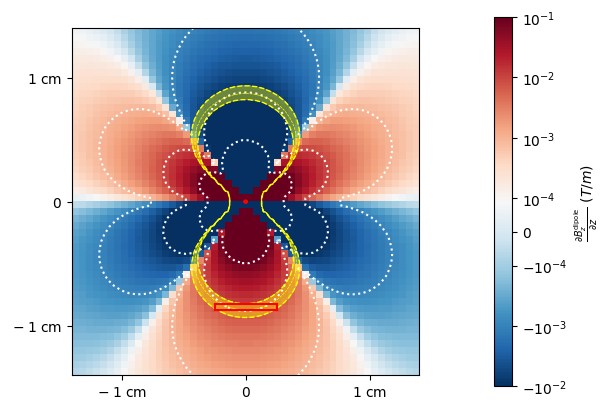

In [3]:
############################################################# MAGNETIC RESONANCE + FIG 4 ####################################################################
def VG_calc(omega_DM, Magnet, Sample, plot_if=False, no_sph=1):
    # Identify DM frequency as rf frequency
    omega_rf = omega_DM
    
    # DC Field
    delta_B_0 = 2e-5
    delta_B_0 = 3e-5
    B_0 = round(omega_rf / gamma - delta_B_0, 6)
    
    # Create plot
    fig, ax = plt.subplots()
    
    # Create meshgrid
    size = 180  * Magnet.R
    size = 140  * Magnet.R
    x, y = np.meshgrid(np.linspace(-size, size, 50), np.linspace(-size, size, 50))
    
    # Plot micromagnet, gradient, and resonance slice
    plot_micromagnet(Magnet.R)
    B_x, B_y, grad_B_2D = micromagnet_field(x, y, Magnet.M_0, Magnet.R)
    plot_gradient(x, y, grad_B_2D, size)
    plot_resonance_slice(x, y, B_x, B_y, B_p, omega_rf, B_0, Sample.T1, Sample.T2)
    
    # Resonance Slice
    x_lower, y_lower, x_upper, y_upper = resonance_slice(x, y, B_x, B_y, B_p, omega_rf, B_0, Sample.T1, Sample.T2)
    
    if Sample.shape == 'sphere':
        # Plot circular sample
        def plot_circle(x_center, y_center):
            x_sample = np.linspace(-Sample.R, Sample.R, 100)
            y_sample_up   =   np.sqrt(Sample.R**2 - x_sample**2) + y_center
            y_sample_down = - np.sqrt(Sample.R**2 - x_sample**2) + y_center
            x_sample = x_sample + x_center
            plt.plot(x_sample, y_sample_up, 'r', x_sample, y_sample_down, 'r')
        y_center = np.min(y_upper) - Sample.R
        x_center = 0
        plot_circle(x_center, y_center)
        if no_sph == 3:
            x_center = 3 * Sample.R
            plot_circle(x_center, y_center)
            x_center = -3 * Sample.R
            plot_circle(x_center, y_center)
    
        #Calculate VG
    
        num = 10
        X, Y, Z = np.linspace(-Sample.R, Sample.R, num), np.linspace(-Sample.R, Sample.R, num), np.linspace(-Sample.R, Sample.R, num)
        dV = (X[1] - X[0])**3
    
        # Calculates VG for each YIG sphere
        def calc_VG(x0, y0, z0):
            V_total, V_res, VG = 0, 0, 0
            for x in X:
                for y in Y:
                    for z in Z:
                        V_total = V_total + dV
                        if x**2+y**2+z**2 <= Sample.R**2:
                            V_res = V_res + dV
                            VG = VG + gradient(x+x0, y+y0, z+z0, Magnet.M_0, Magnet.R) * dV
                            plt.plot(x+x0, z+z0, 'r.')
            return VG
        VG = 0
        
        if no_sph == 3:
            for x_0 in [-3*Sample.R, 0, 3*Sample.R]:
                for y_0 in [-3*Sample.R, 0, 3*Sample.R]:
                    z_0 = np.min(y_upper)-Sample.R 
                    VG = VG + calc_VG(x_0, y_0, z_0)
        elif no_sph == 1:    
            z_0 = np.min(y_upper)-Sample.R 
            VG = VG + calc_VG(0, 0, z_0)
        plt.xticks([-0.01, 0, 0.01], [r'$\rm-1~cm$', r'$0$', r'$\rm 1~cm$'])
        plt.yticks([-0.01, 0, 0.01], [r'$\rm-1~cm$', r'$0$', r'$\rm 1~cm$'])
        
    elif Sample.shape == 'cuboid':
        z0 = np.min(y_upper) - Sample.z
        x1 = -Sample.x
        x2 =  Sample.x
        y1 = -Sample.y
        y2 =  Sample.y
        z1 = -Sample.z + z0
        z2 =  Sample.z + z0
        plt.plot([x1, x1], [z1, z2], 'r')
        plt.plot([x2, x2], [z1, z2], 'r')
        plt.plot([x1, x2], [z1, z1], 'r')
        plt.plot([x1, x2], [z2, z2], 'r')
    
        # Calculate VG    
        num = 10
        X, Y, Z = np.linspace(x1, x2, num), np.linspace(y1, y2, num), np.linspace(z1, z2, num)
        dV = (X[1] - X[0])**3
    
        V_total, V_res, VG = 0, 0, 0
        for x in X:
            for y in Y:
                for z in Z:
                    V_total = V_total + dV
                    r_lower = np.sqrt(x_lower**2 + x_lower**2)
                    r_upper = np.sqrt(x_upper**2 + x_upper**2)
                    if check_res_region(x,y,z, r_lower, y_lower, r_upper, y_upper):
                        V_res = V_res + dV
                        VG = VG + gradient(x, y, z, Magnet.M_0, Magnet.R) * dV
                        # Sanity Check
#                        plt.plot(x, z, 'r.')
    
    plt.xticks([-0.01, 0, 0.01], [r'$\rm-1~cm$', r'$0$', r'$\rm 1~cm$'])
    plt.yticks([-0.01, 0, 0.01], [r'$\rm-1~cm$', r'$0$', r'$\rm 1~cm$'])   
    
    if plot_if:
        plt.savefig('Resonance_Region.jpg', bbox_inches='tight', dpi = 600)
    else: 
        plt.close()
    return B_0, VG 

VG_calc(Giga*Hz, Magnet, Sample, True) 

In [4]:
#################################################################### FORCE SENSITIVITY ####################################################################
def Mechanical_Force(w, Resonator, Cavity):
    Gamma = Resonator.omega / Resonator.Q                                                          # Mechanical damping
    chi_xF = (1/Resonator.m_eff) / (Resonator.omega**2 - w**2 + 1j*w*Gamma/2)                      # Transfer function between x and F
    
    Simp_xx = Cavity.kappa/(16*Cavity.nbar*Cavity.G**2) * (1 + 4*(w/Cavity.kappa)**2)
    Simp_FF = Simp_xx * (np.abs(chi_xF))**(-2)
    Sba_FF = (4*hbar**2*Cavity.nbar*Cavity.G**2)/Cavity.kappa * (1 + 4*(w/Cavity.kappa)**2)**(-1)  #Sba_FF = hbar**2/4 / Simp_xx
    Sth_FF = 4*k_B*T/w * (1/chi_xF).imag

    S_FF = Sba_FF + Sth_FF + Simp_FF
    return {'ba': Sba_FF, 'th': Sth_FF, 'imp':Simp_FF, 'total':S_FF}
    return Simp_FF, Sba_FF, Sth_FF, S_FF

def timing_factor(t_int, omega_DM, DM_field):
    f_DM = omega_DM / (2*np.pi)
    t_DM = 1e6 / f_DM                                          # Coherence Time
    if DM_field[0:5] == 'Axion':
        t_DM = t_DM * 0.68
    return 1 / (t_int * t_DM)**(1/4)

In [5]:
#################################################################### DARK MATTER SENSITIVITY ####################################################################
def g_sens(coupling, omega_p, Resonator, Cavity, Magnet, Sample, t_int, rad_damp = True, noise='total'):
    def Force_to_g(coupling, omega, omega_DM, Magnet, Sample, Noise_Force):
        B_0, VG = VG_calc_new(omega_DM, Magnet, Sample, False)
#        print(VG)
        Dm_z = Noise_Force / VG    
        # Magnetization
        P_0 = np.tanh(mu_B * B_0 / (k_B * T)) 
        m_0 =  Sample.n * mu_B * P_0
        if rad_damp:
            # Radiation Damping
            Tr = c**3/omega_DM**3 * 6*np.pi/(m_0*mu_0*gamma*Sample.V)
            T2star = 1 / (1/Sample.T2 + 1/Tr)
            # Magnetic Field
            B_DM = Dm_z / (m_0 * gamma**2 * Sample.T1 * (T2star**2/Sample.T2) * B_p) 
        else:
            B_DM = Dm_z / (m_0 * gamma**2 * Sample.T1 * Sample.T2 * B_p) 
        print(min(B_DM))
    
        if coupling == 'Axion-Electron':
            return g_ae(B_DM)
        if coupling == 'Axion-Photon':
            return g_agamma(B_DM, B_0, L_exp) / (Giga*eV)**-1 
        if coupling == 'Dark Photon':
            return epsilon(B_DM, (hbar * omega_DM)/c**2, L_exp)

    m1 = np.array([])
    g1 = np.array([])
    
    for omega_DM in [omega_p - Resonator.omega, omega_p + Resonator.omega]:
        m_DM = np.log10((hbar * omega_DM) / eV)
        if omega_DM == omega_p + Resonator.omega:
            m_lower = np.log10(omega_p*hbar / eV)
            m_range1 = np.logspace(m_lower, m_DM, 1000000)
            m_range2 = np.logspace(m_DM, m_DM+100000*(m_DM-m_lower), 1000001)[1:]
        if omega_DM == omega_p - Resonator.omega:
            m_upper = np.log10(omega_p*hbar / eV)
            m_range1 = np.logspace(m_DM-100000*(m_upper-m_DM), m_DM, 1000000)
            m_range2 = np.logspace(m_DM, m_upper, 1000001)[1:]
        m_range = np.concatenate((m_range1, m_range2))      
        m1 = np.append(m1, m_range)
        omega_range = m_range * eV / hbar
        omega = omega_range - omega_p    
    
        S_FF = Mechanical_Force(omega, Resonator, Cavity)
        NEF = np.sqrt(S_FF[noise]) * timing_factor(t_int, omega_range, DM_field=coupling[0:5])
        g = Force_to_g(coupling, omega, omega_DM, Magnet, Sample, NEF)
        g1 = np.append(g1, g)
    return m1, g1

In [ ]:
### Calcluations for Fig 2 panel 1
# Membrane minute-long range
m1, g1 = g_sens('Axion-Electron', 2*np.pi*(Giga*Hz+Mega*Hz), Membrane, Cavity, Magnet, Sample, minute)
m1, g1 = g_sens('Axion-Electron', 2*np.pi*(Giga*Hz+Mega*Hz+(100*day/minute)*0.1*kilo*Hz), Membrane, Cavity, Magnet, Sample, minute)
# Cantilever minute-long range
m1, g1 = g_sens('Axion-Electron', 2*np.pi*(Giga*Hz-30*Mega*Hz), Cantilever, Cavity, Magnet, Sample, minute)
m1, g1 = g_sens('Axion-Electron', 2*np.pi*(Giga*Hz-30*Mega*Hz-(100*day/minute)*0.1*kilo*Hz), Cantilever, Cavity, Magnet, Sample, minute)
# Membrane 100 day-long line
m1, g1 = g_sens('Axion-Electron', 2*np.pi*(Giga*Hz+Mega*Hz), Membrane, Cavity, Magnet, Sample, 100*day)
# Cantilever 100 day-long line
m1, g1 = g_sens('Axion-Electron', 2*np.pi*(Giga*Hz-30*Mega*Hz-(100*day/minute)*0.1*kilo*Hz), Cantilever, Cavity, Magnet, Sample, 100*day)

In [ ]:
### Calculations for Fig 2 panel 2
m1, g1 = g_sens('Axion-Electron', 2*np.pi*Giga*Hz, Membrane, Cavity, Magnet, Sample, 100*day)

In [ ]:
### Calculations for Fig 2 panel 3
f_m = Membrane.omega / (2*np.pi)
omega_test = 2 * np.pi * np.concatenate((np.logspace(3, np.log10(f_m), 100), np.logspace(np.log10(f_m), 5, 101)[1:]))
S_FF = Mechanical_Force(omega_test, Membrane, Cavity)

In [ ]:
### Calculations for Fig 3
# Membrane minute-long range
m1, g1 = g_sens('Dark Photon', 2*np.pi*(f_mid+Mega*Hz), Membrane, Cavity, Magnet, Sample, minute)
m1, g1 = g_sens('Dark Photon', 2*np.pi*(f_mid+Mega*Hz+(100*day/minute)*0.1*kilo*Hz), Membrane, Cavity, Magnet, Sample, minute)
# Cantilever minute-long range
m1, g1 = g_sens('Dark Photon', 2*np.pi*(f_mid-30*Mega*Hz), Cantilever, Cavity, Magnet, Sample, minute)
m1, g1 = g_sens('Dark Photon', 2*np.pi*(f_mid-30*Mega*Hz-(100*day/minute)*0.1*kilo*Hz), Cantilever, Cavity, Magnet, Sample, minute)
# Membrane 100 day-long line
m1, g1 = g_sens('Dark Photon', 2*np.pi*(f_mid+Mega*Hz), Membrane, Cavity, Magnet, Sample, 100*day)
# Cantilever 100 day-long line
m1, g1 = g_sens('Dark Photon', 2*np.pi*(f_mid-30*Mega*Hz-(100*day/minute)*0.1*kilo*Hz), Cantilever, Cavity, Magnet, Sample, 100*day)